# Grape V1 Data Plots
The purpose of this notebook is to provide a one-stop shop for plotting data from the prototype of the Grape 1 Low-Cost Personal Space Weather Station. 

This notebook was created by Kristina Collins KD8OXT. Code was contributed by Aidan Montare KB3UMD and Bob Benedict KD8CGH. Hardware designed by John Gibbons. Node maintainers are listed in the `nodelist.csv` file which accompanies this notebook.

## Instructions:
Data is permanently stored at [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6622112.svg)](https://doi.org/10.5281/zenodo.6622112). To use this notebook, download the data from the repository and unzip it into the `data/` directory.

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import datetime as dt
# from datetime import time
from datetime import date
import time
import pytz
import numpy as np
import seaborn as sns; sns.set_theme()
import matplotlib as mpl
import wget
import os
import matplotlib.pyplot as plt
# from adjustText import adjust_text                                # For map labels
# import tqdm 
import sys  
# sys.path.insert(0, '/path/to/application/app/folder')
from Beacon import readheader                                     # local .py file

# Directory tools:
from os import listdir                                           
from os.path import isfile, join

# multiplot utilities:
from os import path
import sys
import csv
import math
#import shutil  # uncomment for pi
#from datetime import date, timedelta  # uncomment for pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt, butter
import datetime  
from suntime import Sun
from WWV_utility2 import time_string_to_decimals                              # python file in this directory
from Beacon import readheader

from os.path import exists                                                    #  to have wget check for duplicates

import csv                                                                    # to save and read .csv files

from dateutil import parser                                                   # used in multiplot()



# Generate Data Overview
The first step is to pull the list of filenames from the server maintained by the WWV Amateur Radio Club, WW0WWV. We will then generate a pandas dataframe from the filename list using the split() function. This will tell us the earliest and latest dates of data collection; we can use these as the bounds of our analysis, or substitute in a smaller set of bounds. We'll use this to create a Gantt chart showing station availability, and maybe keograms of our data over time. While we're at it, we can also generate two versions of a station map: one static, to put in our paper; and one dynamic, showing which stations were active at a given point in time. 

In [2]:
# List of files:
mypath = 'data/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
df = pd.DataFrame(onlyfiles)
df

0
0     2021-10-02T000000Z_N0000029_G1_DM45dc_FRQ_WWV1...
1     2021-06-13T000000Z_N0000008_S1_EN91fl_FRQ_WWV1...
2     2021-01-06T000000Z_N0000002_S1_EN91fl_FRQ_WWV2...
3     2021-10-11T000000Z_N0000002_S1_EN91fl_FRQ_WWV2...
4     2021-05-22T000000Z_N0000013_S1_DN70ln_FRQ_WWV1...
...                                                 ...
8538  2021-06-30T000000Z_N0000015_G1_FN20mp_FRQ_WWV1...
8539  2021-06-03T015539Z_N0000002_S1_EN91fl_FRQ_WWV2...
8540  2021-12-03T000000Z_N0000029_G1_DM45dc_FRQ_WWV1...
8541  2022-03-01T000000Z_N0000039_G1_EM73ut_FRQ_WWV1...
8542  2022-04-04T000000Z_N0000007_G1_EN91fh_FRQ_WWV1...

[8543 rows x 1 columns]

In [3]:
# Eliminate .pngs from our file list:
df = df[~df[0].str.contains('.png')]
df.columns =['Filename']
df2 = df['Filename'].str.split('_', expand=True)
df2.columns =['Datetime', 'Node', 'G', 'Grid Square', 'FRQ', 'Frequency']
df2 = df2.drop(columns=['FRQ']) # no information in this columnn
df2["Frequency"] = df2["Frequency"].str.replace(".csv","")
df = pd.concat([df2, df], axis = 1) # concatenate dataframes horizontally
df['Datetime']= pd.to_datetime(df['Datetime']) # cast to datetime
df['Node'] =df['Node'].str.strip("N")                   # Ditch the leading N on the node numbers
df['Node'] = df['Node'].astype(str).astype(int)         # Cast node number to int
df = df[~df['Frequency'].str.contains('G1')]            # discarding files with naming errors


# Convert frequency abbreviations to numbers:

df.loc[df['Frequency'] == 'WWV5', 'Frequency'] = 5e6
df.loc[df['Frequency'] == 'WWV10', 'Frequency'] = 10e6
df.loc[df['Frequency'] == 'WWV2p5', 'Frequency'] = 2.5e6
df.loc[df['Frequency'] == 'WWV15', 'Frequency'] = 15e6
df.loc[df['Frequency'] == 'CHU3', 'Frequency'] = 3330e3
df.loc[df['Frequency'] == 'CHU7', 'Frequency'] = 7850e3
df.loc[df['Frequency'] == 'CHU14', 'Frequency'] = 14.67e6
df.loc[df['Frequency'] == 'Unknown', 'Frequency'] = 0

df

/tmp/ipykernel_963370/1827774542.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df2["Frequency"] = df2["Frequency"].str.replace(".csv","")


Datetime  Node   G Grid Square   Frequency  \
0    2021-10-02 00:00:00+00:00    29  G1      DM45dc  10000000.0   
1    2021-06-13 00:00:00+00:00     8  S1      EN91fl  10000000.0   
2    2021-01-06 00:00:00+00:00     2  S1      EN91fl   2500000.0   
3    2021-10-11 00:00:00+00:00     2  S1      EN91fl   2500000.0   
4    2021-05-22 00:00:00+00:00    13  S1      DN70ln  10000000.0   
...                        ...   ...  ..         ...         ...   
8538 2021-06-30 00:00:00+00:00    15  G1      FN20mp  10000000.0   
8539 2021-06-03 01:55:39+00:00     2  S1      EN91fl   2500000.0   
8540 2021-12-03 00:00:00+00:00    29  G1      DM45dc  10000000.0   
8541 2022-03-01 00:00:00+00:00    39  G1      EM73ut  10000000.0   
8542 2022-04-04 00:00:00+00:00     7  G1      EN91fh  10000000.0   

                                               Filename  
0     2021-10-02T000000Z_N0000029_G1_DM45dc_FRQ_WWV1...  
1     2021-06-13T000000Z_N0000008_S1_EN91fl_FRQ_WWV1...  
2     2021-01-06T000000Z_N0000002_S1_EN91fl_FRQ_WWV2...  
3     2021-10-11T000000Z_N0000002_S1_EN91fl_FRQ_WWV2...  
4     2021-05-22T000000Z_N0000013_S1_DN70ln_FRQ_WWV1...  
...                                                 ...  
8538  2021-06-30T000000Z_N0000015_G1_FN20mp_FRQ_WWV1...  
8539  2021-06-03T015539Z_N0000002_S1_EN91fl_FRQ_WWV2...  
8540  2021-12-03T000000Z_N0000029_G1_DM45dc_FRQ_WWV1...  
8541  2022-03-01T000000Z_N0000039_G1_EM73ut_FRQ_WWV1...  
8542  2022-04-04T000000Z_N0000007_G1_EN91fh_FRQ_WWV1...  

[8542 rows x 6 columns]

In [4]:
# We can create a Gantt chart showing when different stations were active. 
gantt = df.copy()

# # # Filter by day:
sTime_tmp = datetime.datetime(2021,10,28, tzinfo = pytz.UTC)
eTime_tmp = datetime.datetime(2021,10,29, tzinfo = pytz.UTC)
# gantt = gantt[(gantt['Datetime'] >= sTime_tmp) & (gantt['Datetime'] <= eTime_tmp)].copy()


# List of logged nodes during the period of interest, for sorting:
logged_nodes = df["Node"].unique().tolist()
logged_nodes.sort()

gantt.set_index('Node')
gantt = gantt.drop(columns=['G', 'Grid Square'])#, 'Filename'])
gantt['EndTime'] = gantt['Datetime']+ datetime.timedelta(days=1) # create an end
# For now, let's look at one frequency at a time.
# rows = gantt['Frequency']=='WWV5' # can change this to look at a different freq of interest.
# gantt = gantt.loc[gantt['Frequency'] == 'WWV2p5']

gantt['Filename'].str.strip('FRQ_')

# fig = px.timeline(gantt, x_start="Datetime", x_end="EndTime", y="Node", color="Frequency", text = "Filename", category_orders={"Node": logged_nodes})
fig = px.timeline(gantt, x_start="Datetime", x_end="EndTime", y="Node", color="Frequency", category_orders={"Node": logged_nodes})
# fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.update_yaxes(type='category')
fig.update_annotations(text = "Filename", clicktoshow='on')


fig.show()
fig.write_html("gantt.html", include_plotlyjs="cdn")

In [5]:
# Read in node list:
nodes = pd.read_csv ('nodelist.csv',  encoding='cp1252')
nodes = nodes[1:42] # discarding extra rows - this should be dynamically assigned, but is manual for now.
nodes = nodes.rename(columns={'Node #': 'Node_Number'})

# Just the nodes that have data:
# logged_nodes = df["Node"].unique().tolist()
# logged_nodes.sort()
# logged_nodes = [s.lstrip('N') for s in logged_nodes]
test_list = list(map(int, logged_nodes)) # cast to int

# tf = nodes['Node #']logged_nodes[] # true/false vector
# nodes['Node #'] in logged_nodes
# nodes['Node #']
nodes['Status'] = np.where((nodes.Node_Number.isin(logged_nodes)), "Data logged", "No data logged")
nodes

color = (nodes['Status'] == 'No data logged').map({True: 'background-color: pink', False: ''})
nodes.style.apply(lambda s: color)

In [6]:
# Map nodes:
fig = px.scatter_geo(nodes, "Latitude", "Longitude",
                     color="Status", # which column to use to set the color of markers
                     hover_name=nodes["Callsign"], # column added to hover information
                     projection = 'albers usa',
                     )

fig.show()

## Example of a concurrent daily plot
Let's use the multiplot function developed by Bob Benedict KD8CGH (https://github.com/rkayakr/ProcessPlot) to plot Grape data from multiple stations on the same date. October 28, 2021 is a good example date, because there were solar flares widely observed by Grape 1 stations.

The `multiplot` function is adapted from KD8CGH's code. It checks a text file in the local directory for the set of files to plot. We'll define the function, then make a list of files and call it. 

This version of `multiplot()` also makes it easy to plot the sunrise and sunset times for a given station, or add a vertical line at the time of an event. By default, these functions are not enabled. 

In [7]:
def multiplot(plotTitle = ' Grape Data Plot', plot_sun = False, plot_event = False, eventTime = '2021-10-28 15:35:00+00:00', eventlabel = 'X1 Class Solar Flare'):
    '''
        # !/usr/bin/env python3
    # -*- coding: utf-8 -*-
    PROCESSED FILE VERSION V1.0 built on multiPlot v1.2
    multiPlot version v1.2 cleans up to make Pi and Windows use easier
    multiPlot version v1.1 adds sunrise sunset times for location of lat long in first file
    requires suntime library https://github.com/SatAgro/suntime
    multiPlot version v1.0 plots up to 10 PSWS "rawdata" files and average value
    modified from WWV_plt2.py @authors dkazdan jgibbons
    expects a homepath directory with processed files in homepath or subdirs 
    leaves plot in Mplot directory
    plots files from multiple subdir to compare node results
    plot title from first file
    windows version hardcoded homepath directory location
    for Pi comment out windows homepath and uncomment Pi  lines
    uses WWV_utility2.py
    Bob Benedict, KD8CGH, 7/29/2021
    create text file "plotfiles.txt" in homepath directory
      keyword ('Doppler' or 'Power')
      keyword ('Average' or 'No Average')
      subdir/filename1 
      subdir/filename2
      filename3
      ...
    Note - expects all data from the same beacon
    if found 'Doppler' will plot Doppler shifts, else will plot Power
    if found "Average" will add average plot
    loads file names in list
    plots first file and create axis and title info
    plots rest in loop as curves on first plot
    calculates average and plots
    leaves plotfile in Mplot directory
    uses
    WWV_utility2.py
    20 February 2020
    WWV utility file
    Routines and classes used in WWV file management and graphing
    David Kazdan, AD8Y
    John Gibbons, N8OBJ - mods to plot header 2/3/20
    '''

    #import os # uncomment for pi
    from os import path
    import sys
    import csv
    import math
    #import shutil  # uncomment for pi
    #from datetime import date, timedelta  # uncomment for pi
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import filtfilt, butter
    import datetime  
    from suntime import Sun
    #import subprocess
    from WWV_utility2 import time_string_to_decimals
    from Beacon import readheader

    '''  #uncomment for Pi
    # ~ points to users home directory - usually /home/pi/
    homepath = os.path.expanduser('~')
    # embed the trailing / in the home path
    homepath = homepath + "/PSWS/"
    #comment out windows homepath
    '''

    homepath = ""#E:\\Documents\\PSWS\\"  # set your windows path, comment out for Pi

    names = open(homepath+"Processfiles.txt","r")

    PlotTarget = names.readline()
    PlotTarget = PlotTarget.strip('\n')
    PlotAverage = names.readline()
    if PlotAverage[0:7] == 'Average':
        doavg=True
    else:
        doavg=False

    Filenames=['a' for a in range (10)]
    Filedates=['a' for a in range (10)]
    #PrFilenames=['a' for a in range (10)]
    Nodenum=['a' for a in range (10)]
    Beaconname=['a' for a in range (10)]
    beaconfreq=np.zeros(10)

    nfiles = 0  # holder for number of files to plot

    colors=['b','g','r','c','m','y','tab:orange','tab:gray','tab:purple','tab:brown']

    while True:
        temp = names.readline()
        if  len(temp) <= 1:
            break
        Filenames[nfiles]=temp.strip("\n")
        fdate = Filenames[nfiles].find("/") # find start of filename after subdirectory
        if fdate==-1 :  # if / not found try \
            fdate = Filenames[nfiles].find("\\")
    #    print(" position ",fdate)
        # if neith / nor \ found file is in homepath, fdate=-1, following assignment still works
        Filedates[nfiles]=temp[fdate+1:fdate+11]
        nfiles=nfiles + 1

    print(Filenames[0:9])
    #print(Filedates[0:9])
    print('number of files',nfiles)
    if nfiles > 10 :
        print('10 file limit')
        sys.exit(0)

    PROCESSDIR = homepath

    #saved plot directory
    PlotDir = homepath + 'Mplot/'

    '''
    read first file
    '''
    PrFilenames=(PROCESSDIR + Filenames[0])

    if (path.exists(PrFilenames)):
        print('File ' + PrFilenames + ' found!\nProcessing...')
    else:
        print('File ' + PrFilenames + ' not available.\nExiting disappointed...')
        sys.exit(0)

    with open(PrFilenames, 'r') as dataFile:
        dataReader=csv.reader(dataFile)
        data = list(dataReader)
        Header = data.pop(0)

    #    print('return',readheader(0,Header))
        Nodenum[0], Beaconname[0], beaconfreq[0], Lat, Long = readheader(Header)
    #    print('\n returned ', Nodenum[0], Beaconname[0], beaconfreq[0], Lat, Long, '\n')

    ''' ###########################################################################
    '''
    print('Ready to start processing records')

    # Prepare data arrays
    hours=[[],[],[],[],[],[],[],[],[],[]]
    Doppler=[[],[],[],[],[],[],[],[],[],[]]
    #Vpk=[[],[],[],[],[],[],[],[],[],[]]
    Power_dB=[[],[],[],[],[],[],[],[],[],[]] # will be second data set, received power 9I20
    filtDoppler=[[],[],[],[],[],[],[],[],[],[]]
    filtPower=[[],[],[],[],[],[],[],[],[],[]]

    LateHour=False # flag for loop going past 23:00 hours

    # eliminate all metadata saved at start of file - Look for UTC (CSV headers)
    #find first row of data0
    FindUTC = 0

    for row in data:
        if (FindUTC == 0):
            #print('looking for UTC - row[0] =',row[0])
            if (row[0] == 'UTC'):
                FindUTC = 1
    #            print('UTC found =', row[0])
        else:
            #print('Processing record')
            decHours=time_string_to_decimals(row[0])
    #        if (NewHdr != 'New'):
    #            if (calccnt  < 101):
    #                calcnt = calcnt+1
    #                freqcalc = freqcalc + (float(row[1])/100)
    #        if decHours > 23:
    #            LateHour=True # went past 23:00 hours
            if (not LateHour) or (LateHour and (decHours>23)): # Otherwise past 23:59:59.  Omit time past midnight.
                hours[0].append(decHours) # already in float because of conversion to decimal hours.
                Doppler[0].append(float(row[1])-beaconfreq[0]) # frequency offset from col 2
    #            Vpk[0].append (float(row[2])) # Get Volts peak from col 3
                Power_dB[0].append (20*math.log10(float(row[2]))) # log power from col 4

    #print('nf ',0,'len hours',len(hours[0]))

    ###############################################################################################
    # Find max and min of Power_dB for graph preparation:
    min_power=np.amin(Power_dB[0]) # will use for graph axis min
    max_power=np.amax(Power_dB[0]) # will use for graph axis max

    min_Doppler=np.amin(Doppler[0]) # min Doppler
    max_Doppler=np.amax(Doppler[0]) # max Doppler

    print('\nDoppler min: ', min_Doppler, '; Doppler max: ', max_Doppler)
    print('dB min: ', min_power, '; dB max: ', max_power)

    #%% Create an order 3 lowpass butterworth filter.
    # This is a digital filter (analog=False)
    # Filtering at .01 to .004 times the Nyquist rate seems "about right."
    # The filtering argument (Wn, the second argument to butter()) of.01
    # represents filtering at .05 Hz, or 20 second weighted averaging.
    # That corresponds with the 20 second symmetric averaging window used in the 1 October 2019
    # Excel spreadsheet for the Festival of Frequency Measurement data.
    #FILTERBREAK=.005 #filter breakpoint in Nyquist rates. N. rate here is 1/sec, so this is in Hz.
    FILTERBREAK=0.005 #filter breakpoint in Nyquist rates. N. rate here is 1/sec, so this is in Hz.
    FILTERORDER=6
    b, a = butter(FILTERORDER, FILTERBREAK, analog=False, btype='low')
    #print (b, a)
    #%%
    # Use the just-created filter coefficients for a noncausal filtering (filtfilt is forward-backward noncausal)


    filtDoppler[0] = filtfilt(b, a, Doppler[0])

    filtPower[0] = filtfilt(b, a, Power_dB[0])

    ##################################################################################################
    # sunrise sunset times in UTC
    sun = Sun(float(Lat), float(Long))

    UTC_DT=Filedates[0]
    print(UTC_DT)
    SDAY=int(UTC_DT[8:10])
    SMON=int(UTC_DT[5:7])
    SYEAR=int(UTC_DT[0:4])
    sdate = datetime.date(SYEAR, SMON, SDAY)
    event = parser.parse(eventTime)                              # Event time is parsed
    print(event)
    evh=int(format(event.strftime('%H')))                        # ...take the hour....
    evm=int(format(event.strftime('%M')))                        #.........and the minute...
    evx=evh+evm/60                                               # ...to find where the vertical line goes on the plot.
    today_sr = sun.get_sunrise_time(sdate)
    today_ss = sun.get_sunset_time(sdate)
    srh=int(format(today_sr.strftime('%H')))
    srm=int(format(today_sr.strftime('%M')))
    srx=srh+srm/60
    ssh=int(format(today_ss.strftime('%H')))
    ssm=int(format(today_ss.strftime('%M')))
    ssx=ssh+ssm/60

    # set up x-axis with time
    fig = plt.figure(figsize=(19,10)) # inches x, y with 72 dots per inch
    ax = fig.add_subplot(111)
    ax.set_xlabel('UTC Hour')
    ax.set_xlim(0,24) # UTC day
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], minor=False)

    # plot first curve
    if (PlotTarget == 'Doppler'):
        if plot_sun == True:
            ax.plot([srx,srx],[-1,1],'y',label='Sunrise: ' + str(today_sr), linestyle='dashed')      # plot sunrise for first station
            ax.plot([ssx,ssx],[-1,1],'b',label='Sunset: '  + str(today_ss), linestyle='dashed')       # sunset for first station
        if plot_event == True:
            print('Plotting event: ' + eventlabel + ' at ' + str(event))
            ax.plot([evx,evx],[-1,1],'k',label=eventlabel + ' at ' + str(event),linestyle='dashed')
        ax.plot(hours[0], filtDoppler[0], colors[0],label=Beaconname[0] +' '+Nodenum[0]+' '+Filedates[0]) # color k for black
        ax.set_ylabel('Doppler shift, Hz '+ Filedates[0])
        ax.set_ylim([-1.0, 1.0]) # -1 to 1 Hz for Doppler shift
        plt.axhline(y=0, color="gray", lw=1) # plot a zero freq reference line for 0.000 Hz Doppler shift


    else:                                 # Plotting power:
        if plot_sun == True:
            ax.plot([srx,srx],[-90, 0],'y',label='Sunrise: ' + str(today_sr), linestyle='dashed')      # plot sunrise for first station
            ax.plot([ssx,ssx],[-90, 0],'b',label='Sunset: '  + str(today_ss), linestyle='dashed')       # sunset for first station
        if plot_event == True:
            print('Plotting event: ' + eventlabel + ' at ' + str(event))
            ax.plot([evx,evx],[-90, 0],'k',label=eventlabel + ' at ' + str(event),linestyle='dashed')
        ax.plot(hours[0], filtPower[0], colors[0],label=Beaconname[0] +' '+ Nodenum[0]+' '+Filedates[0]) # color k for black
        ax.set_ylabel('Power, dB '+ Filedates[0])
        ax.set_ylim(-90, 0)    


    # add grid lines - RLB
    plt.grid(axis='both')

    '''
    ######################################################################
    read and plot files loop
    '''

    for nf in range(1, nfiles):
    # splot second curve
    # read second file, skip header
        print('process file ',nf, Filenames[nf])
        PrFilenames=(PROCESSDIR + Filenames[nf])
        with open(PrFilenames, 'r') as dataFile: # read second set
            dataReader=csv.reader(dataFile)
            data = list(dataReader)
            Header = data.pop(0)
            Nodenum[nf]= Header[2]
        FindUTC = 0

        Nodenum[nf], Beaconname[nf], beaconfreq[nf], Lat, Long = readheader(Header)
    #    print('\n returned ', Nodenum[nf], Beaconname[nf], beaconfreq[nf], Lat, Long, '\n')

        for row in data:
            if (FindUTC == 0):
                #print('looking for UTC - row[0] =',row[0])
                if (row[0] == 'UTC'):
                    FindUTC = 1
    #            print('UTC found =', row[0])
            else:
                decHours=time_string_to_decimals(row[0])
                hours[nf].append(decHours) # already in float because of conversion to decimal hours.
                Doppler[nf].append(float(row[1])-beaconfreq[nf]) # frequency offset from col 2
    #            Vpk[nf].append (float(row[2])) # Get Volts peak from col 3
    #            Power_dB[nf].append (float(row[4])) # log power from col 4    
                Power_dB[nf].append (20*math.log10(float(row[2]))) # log power
    # filter  file data
        filtDoppler[nf] = filtfilt(b, a, Doppler[nf])
        filtPower[nf] = filtfilt(b, a, Power_dB[nf])

        if (PlotTarget == 'Doppler'):    
            ax.plot(hours[nf], filtDoppler[nf], colors[nf], label=Beaconname[nf] +' '+ Nodenum[nf]+' '+Filedates[nf]) # color k for black
        else:
            ax.plot(hours[nf], filtPower[nf], colors[nf], label=Beaconname[nf] +' '+ Nodenum[nf]+' '+Filedates[nf]) # color k for black

    '''
    #############################################################################
    end for read and plot loop, start average
    '''
    # find shortest data set, limit average to that
    if doavg :
        al=1000000
        ak=0

        for k in range(nfiles):
            templ=len(hours[k])
            if templ < al:
                al=templ
                ak=k

        avg=[]

        if (PlotTarget == 'Doppler'):
            for i in range(al):
                temp=0.0
                for j in range(nfiles):
                    temp=temp+filtDoppler[j][i]
                temp=temp/nfiles
                avg.append(temp)
        else:
            for i in range(al):
                temp=0.0
                for j in range(nfiles):
                    temp=temp+filtPower[j][i]
                temp=temp/nfiles
                avg.append(temp)

        #print('avg',len(avg))

        ax.plot(hours[ak], avg, 'k', label='Average') # color k for black

    '''
    end average
    '''
    ax.legend(loc="lower right",  frameon=False)


    # Create Plot Title
    plt.title(plotTitle)
    #plt.title(beaconlabel + ' Grape Data Plot\nNode:  ' + node + '     Gridsquare:  '+ GridSqr + '\nLat= ' + Lat + '    Long= ' + Long + '    Elev= ' + Elev + ' M\n' )
    # Create Plot File Nam
    #GraphFile = yesterdaystr + '_' + node + '_' + RadioID + '_' + GridSqr + '_' + beacon + '_graph.png'
    GraphFile = 'multi'+ PlotTarget + '.png'
    PlotGraphFile = PlotDir + GraphFile

    # create plot
    #plt.savefig(PlotDir + yesterdaystr + '_' + node + '_' +  GridSqr + '_' +  RadioID + '_' +  beacon + '_graph.png', dpi=250, orientation='landscape')
    plt.savefig(PlotDir + GraphFile, dpi=250, orientation='landscape')
    # =============================================================================

    print('Plot File: ' + GraphFile + '\n')  # indicate plot file name for crontab printout

    return fig
    #-------------------------------------------------------------------
    print('Exiting python multi plot program gracefully')
    



We'll make a list of files:

['data/2021-10-28T000000Z_N00010_G1_EN91ii_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N0000034_G1_FN13wd_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N0000013_S1_DN70ln_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N00009_G1_FN20ge_FRQ_WWV10.csv', 'a', 'a', 'a', 'a', 'a']
number of files 4
File data/2021-10-28T000000Z_N00010_G1_EN91ii_FRQ_WWV10.csv found!
Processing...
New Header String Detected

corrected UTCDTZ = 2021-10-28T000000Z
Plot for Decoded 10MHz WWV Beacon

Ready to start processing records

Doppler min:  -2.044999999925494 ; Doppler max:  1.9660000000149012
dB min:  -92.39577516576787 ; dB max:  -60.44552789422305
2021-10-28
2021-10-28 15:35:00+00:00
process file  1 data/2021-10-28T000000Z_N0000034_G1_FN13wd_FRQ_WWV10.csv
New Header String Detected

corrected UTCDTZ = 2021-10-28T000000Z
Plot for Decoded 10MHz WWV Beacon

process file  2 data/2021-10-28T000000Z_N0000013_S1_DN70ln_FRQ_WWV10.csv
New Header String Detected

corrected UTCDTZ = 2021-10-28T000000Z
Plot for Decoded 10MHz WWV 

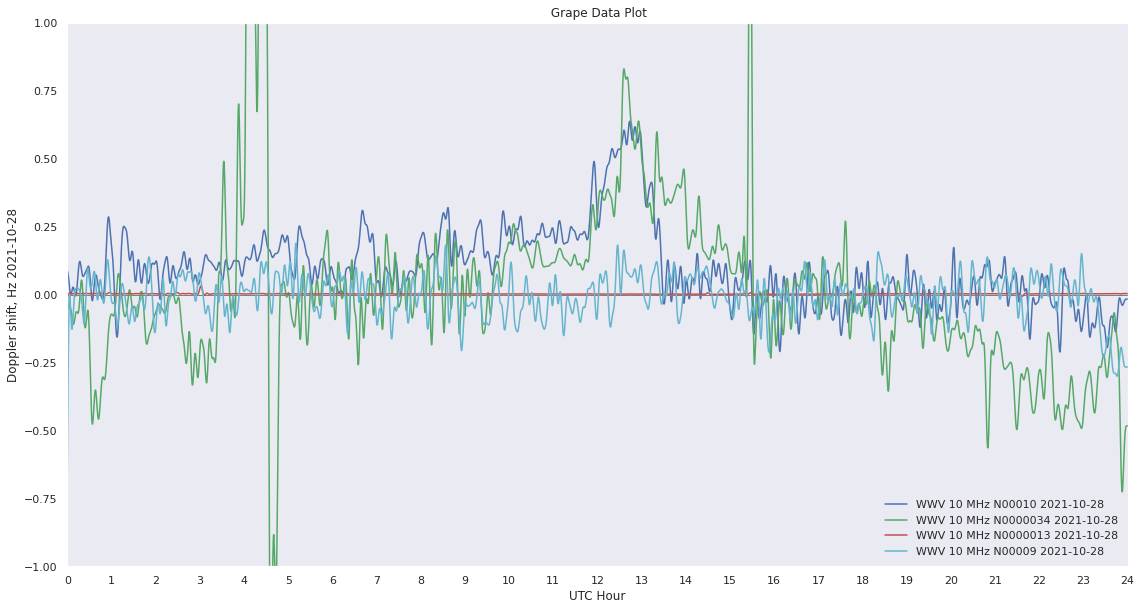

In [8]:
def gather(gantt = df, Freq = 10e6, start = [2018, 1, 1, 0, 0, 0], end = [date.today().year, date.today().month, date.today().day]):
    plotfiles = gantt.loc[gantt['Frequency'] == Freq]                        # only a specific frequency...
    sTime_tmp = dt.datetime(start[0], start[1], start[2], tzinfo = pytz.UTC)
    eTime_tmp = dt.datetime(end[0], end[1], end[2], tzinfo = pytz.UTC)
    namelist = plotfiles[(plotfiles['Datetime'] >= sTime_tmp) & (plotfiles['Datetime'] <= eTime_tmp)].Filename
    return namelist


def listsave(names, listname = "Processfiles.txt", path = 'data/', plot_Power = False, plot_Average = False):
    textfile = open(listname, "w")                             # write list to text file for multiplot, below
    if plot_Power:
        textfile.write('Power' +  "\n")
    else:
        textfile.write('Doppler' +  "\n")
    if plot_Average:
        textfile.write('Average' +  "\n")
    else:
        textfile.write('No Average' +  "\n")
    for element in names:
        textfile.write(path+element +  "\n")
    textfile.close()


# Note: the multiplot routine will only work for a single day's worth of data.
namelist = gather(gantt=df, start = [2021, 10, 28], end = [2021, 10, 28])
names=namelist.values.tolist()
names = names[0:4]                                                   # select specific rows...
listsave(names, plot_Power = False, plot_Average = False)              # Example 

names

# # ....and plot:
foo = multiplot()

Let's add a line for that solar flare:

['data/2021-10-28T000000Z_N00010_G1_EN91ii_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N0000034_G1_FN13wd_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N0000013_S1_DN70ln_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N00009_G1_FN20ge_FRQ_WWV10.csv', 'a', 'a', 'a', 'a', 'a']
number of files 4
File data/2021-10-28T000000Z_N00010_G1_EN91ii_FRQ_WWV10.csv found!
Processing...
New Header String Detected

corrected UTCDTZ = 2021-10-28T000000Z
Plot for Decoded 10MHz WWV Beacon

Ready to start processing records

Doppler min:  -2.044999999925494 ; Doppler max:  1.9660000000149012
dB min:  -92.39577516576787 ; dB max:  -60.44552789422305
2021-10-28
2021-10-28 15:35:00+00:00
Plotting event: X1 Class Solar Flare at 2021-10-28 15:35:00+00:00
process file  1 data/2021-10-28T000000Z_N0000034_G1_FN13wd_FRQ_WWV10.csv
New Header String Detected

corrected UTCDTZ = 2021-10-28T000000Z
Plot for Decoded 10MHz WWV Beacon

process file  2 data/2021-10-28T000000Z_N0000013_S1_DN70ln_FRQ_WWV10.csv
New Header String Detected


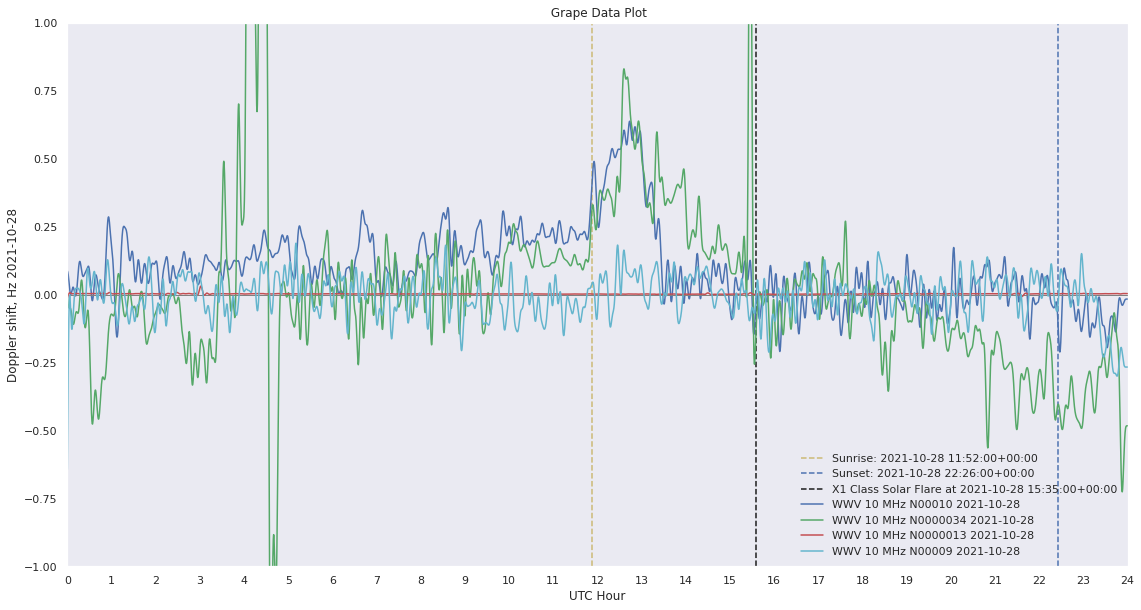

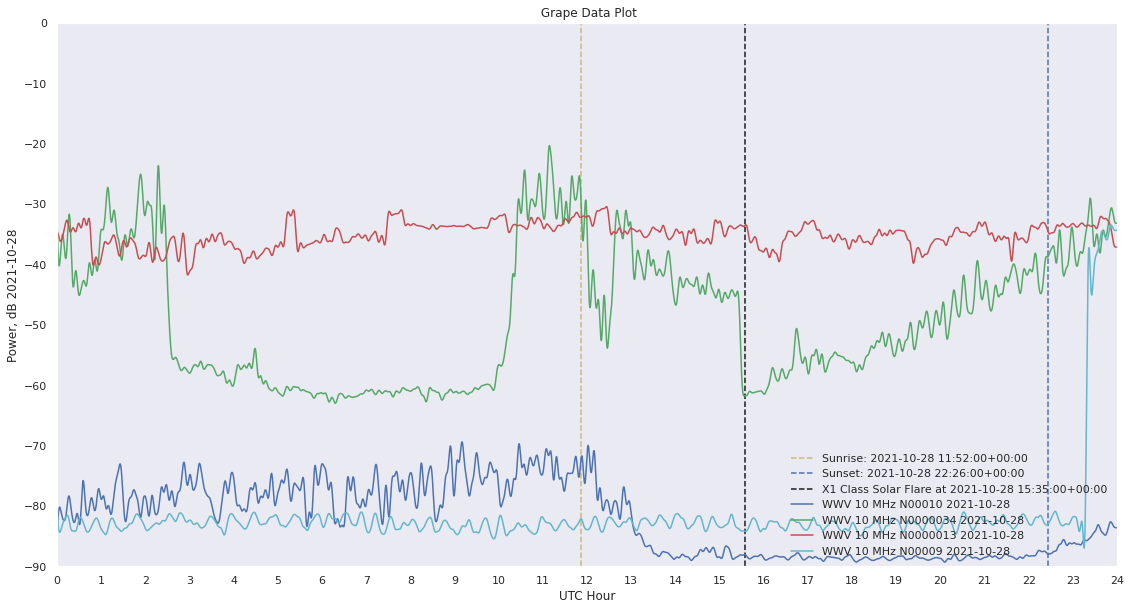

In [9]:
namelist = gather(gantt=df, start = [2021, 10, 28], end = [2021, 10, 28])
names=namelist.values.tolist()
names = names[0:4]                                                   # select specific rows...

listsave(names, plot_Power = False, plot_Average = False)              # Example 
foo = multiplot(plot_sun = True, plot_event = True, eventTime = '2021-10-28 15:35:00+00:00', eventlabel = 'X1 Class Solar Flare')

listsave(names, plot_Power = True, plot_Average = False)              # Example 
foo = multiplot(plot_sun = True, plot_event = True, eventTime = '2021-10-28 15:35:00+00:00', eventlabel = 'X1 Class Solar Flare')

We can also use the multiplot function to plot data for a single station by restricting the `names`, and automatically compute the sunrise and sunset times for that station. Check out Figure 12 here for more information about this: https://www.hardware-x.com/article/S2468-0672(22)00034-7/fulltext#secst075

If more than one day is included, or more than one station, the sunrise and sunset calculations will be made for the first day and station appearing in the list. Here's an example of two concurrent days of data from N8OBJ, plotted on top of one another: 

['data/2019-10-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv', 'data/2019-10-02T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
number of files 2
File data/2019-10-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv found!
Processing...
New Header String Detected

corrected UTCDTZ = 2019-10-01T000000Z
Plot for Decoded 5MHz WWV Beacon

Ready to start processing records

Doppler min:  -7.13399999961257 ; Doppler max:  6.599000000394881
dB min:  -43.40620718202058 ; dB max:  -7.4557152645529525
2019-10-01
2021-10-28 15:35:00+00:00
process file  1 data/2019-10-02T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
New Header String Detected

corrected UTCDTZ = 2019-10-02T000000Z
Plot for Decoded 5MHz WWV Beacon

Plot File: multiDoppler.png

['data/2019-10-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv', 'data/2019-10-02T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
number of files 2
File data/2019-10-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv found!
Processi

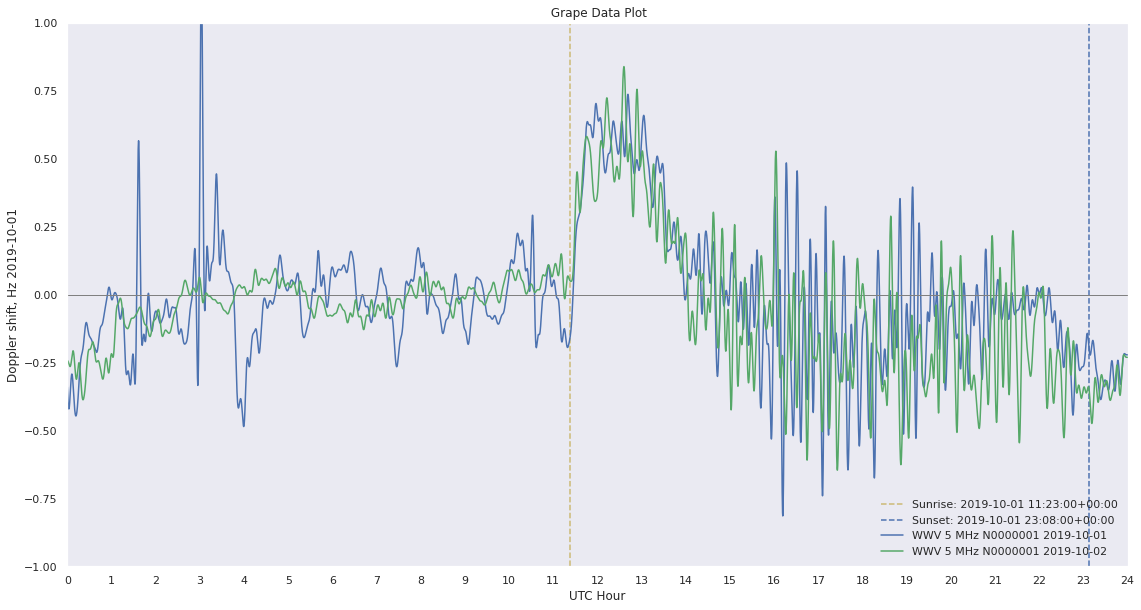

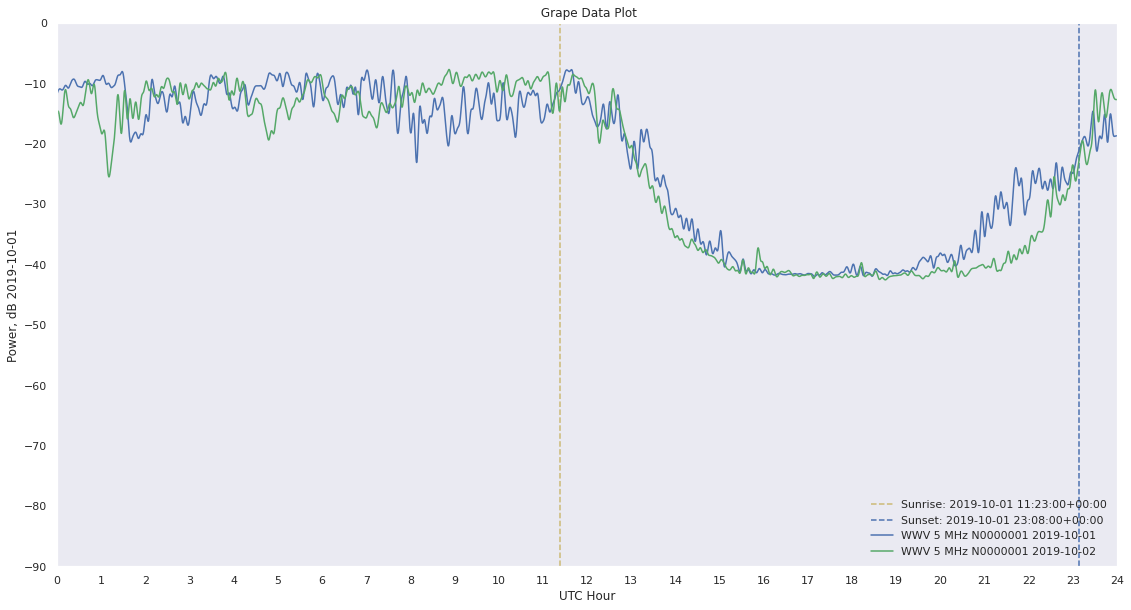

In [10]:
namelist = gather(gantt=df, Freq = 5e6, start = [2019, 10, 1], end = [2019, 10, 2])
names=namelist.values.tolist()
# names = names[0:1]                                                   # select specific rows...
listsave(names, plot_Power = False, plot_Average = False)              # Example 

# ....and plot:
foo = multiplot(plot_sun = True)

listsave(names, plot_Power = True, plot_Average = False)              # Example 
# ....and plot:
foo = multiplot(plot_sun = True)


## Keogram of long-term data
Let's generate a heatmap of one node's data to show trends over the long term.

In [11]:
# Set colormap parameters for keograms. Red/Blue suits Doppler shift.

color = plt.get_cmap('RdBu').copy()   # default color
color.set_bad('black')         # distinct color if value is bad. Try "lightblue" for something milder...

In [12]:
# Define function to generate a heatmap matrix - given node, dates, frequency:
def keomaker(nodenum, start = [2018, 1, 1, 0, 0, 0], end = [date.today().year, date.today().month, date.today().day], 
             cfreq = 5e6, cadence = '5min', quant='freq', df = df):
    tic = time.time()                                                       # set up time clock to see how long this takes
    # First we select stations of interest:
    keolist = df[df['Node']==nodenum]         # selecting one node
    
    #saved data directory
    homepath = ""
    path = homepath + 'data/'
    
#     namelist = gather(gantt=keolist, start = start, end = end)                # bug passing variables
    gantt = keolist
    plotfiles = gantt.loc[gantt['Frequency'] == cfreq] # only a specific frequency...
    sTime_tmp = datetime.datetime(start[0], start[1], start[2], tzinfo = pytz.UTC)
    eTime_tmp = datetime.datetime(end[0], end[1], end[2], tzinfo = pytz.UTC)
    namelist = plotfiles[(plotfiles['Datetime'] >= sTime_tmp) & (plotfiles['Datetime'] <= eTime_tmp)].Filename
    print(str(len(namelist)) + ' files found.')
    
    
    names=namelist.values.tolist()
    listsave(names)
    
    toc = time.time() - tic                                     # See how much time has passed
    print(str(toc) + ' seconds to set up keolist.')             # Feedback to user
    
    toc = time.time() - tic                                     # See how much time has passed
    print("Files downloaded at " + str(toc) + ' seconds.')             # Feedback to user
    keofiles = keolist["Filename"].tolist() # generate a list of filenames
    urls = ["https://wwvarc.org/wwvarc.net/ftp/grape/" + s for s in keofiles]

    # Preallocate:
    sTime_tmp = dt.datetime(start[0], start[1], start[2], tzinfo = pytz.UTC)
    eTime_tmp = dt.datetime(end[0], end[1], end[2], tzinfo = pytz.UTC)
    t = pd.date_range(start=sTime_tmp,
                      end=eTime_tmp,
                      freq = cadence)
    keo = pd.DataFrame(np.nan, index=t, columns=[quant])
    keo[quant] = 0
    keo = pd.pivot_table(keo, index=keo.index.time, columns=keo.index.date, values=quant)  # Create pivot table
    keo.columns = keo.columns.astype(str)                                                  # To match data index
    print("Table of values preallocated from " + keo.columns[1]  + " to " + keo.columns[keo.shape[1]-1]  + ". ")
    print("Table size: " + str(keo.shape))


    for url in names:
        try:
            toc = time.time() - tic                                     # See how much time has passed
    #         print('At ' + str(toc) + ' seconds, started downloading ' + url)             # Feedback to user
            rawdata    = pd.read_csv('data/' + url.strip('\n'), comment = '#', parse_dates=[0])
            toc = time.time() - tic                                     # See how much time has passed
    #         print('At ' + str(toc) + ' seconds, started parsing ' + url)             # Feedback to user
            data = rawdata.drop_duplicates(subset=['UTC'], keep='last')      # drop duplicates
            datestring = data['UTC'].iloc[4].date().strftime('%Y-%m-%d')     # what's the date?
            current_date = data['UTC'].iloc[4].date()
            data['UTC'] = pd.to_datetime(data['UTC'], utc=True)             # convert from string to datetime
            data = data.set_index(['UTC'])                                   # index by datetime
            data = data.resample(cadence).pad()                               # Resample *within* for loop
            data.index = pd.Series([val.time() for val in data.index])       # Ditch date from datetime

            if quant == 'amp':
                data = data.drop(columns = ['Freq'])
                print('Looking at amplitude.')
            if quant == 'freq':
                data = data.drop(columns = ['Vpk'])                          # let's just look at frequency information.
                data['Freq'] = data['Freq']-cfreq                           # Remove the offset from the freq column.
            Freq_string= datestring                                          # Rename col with date
            Vpk_string = "Vpk: " + datestring                                # Rename col with date
            data = data.rename(columns={'Freq': datestring, 'Vpk': datestring})
            toc = time.time() - tic                                     # See how much time has passed
    #         print('At ' + str(toc) + ' seconds, finished reformatting ' + url)             # Feedback to user
            keo.loc[:, datestring] = data          # Maybe try this?
    #         os.remove(filename) #  comment in to delete the file from the working directory when we're done using it

            toc = time.time() - tic                                     # See how much time has passed
            print('At ' + str(toc) + ' seconds, merged ' + url)             # Feedback to user
        except Exception as e:
            print('Ran into an issue with ' + str(url))
            raise e
            continue
            
    toc = time.time() - tic                                     # See how much time has passed
    print(str(toc) + ' seconds to complete this task.')         # Feedback to user
    return keo


In [13]:
# Illustrative keogram for N8OBJ's Node 1, our longest dataset:
node = 1
cfreq = 5e6
cadence = '5min'
quant = 'freq'
keo = keomaker(nodenum=node, start = [2019, 6, 1, 0, 0, 0], end = [2022, 6, 1, 0, 0, 0], cfreq=cfreq, cadence=cadence, quant=quant)

color = plt.get_cmap('RdBu')   # red/blue colormap for Doppler
h_map = sns.heatmap(data=keo, cmap=color, robust = 1, center = 0,  vmin=-.45, vmax=.45, cbar_kws={'label':'Doppler shift (Hz)'})

# Generate plot title:
plotTitle = 'Node ' + str(node)+' ('+nodes.Callsign[node]+') on ' + str(cfreq/1e6)+' MHz at '+cadence + ' cadence'

# Set title and labels for axes
h_map.set(xlabel="Date",
       ylabel="Time of Day (UTC)",
       title=plotTitle)

# Save our plot:
plt.autoscale()
homepath = ""
PlotDir = homepath + 'keoplot/' 
plt.savefig(PlotDir + plotTitle + '_' + quant + '.png', dpi=250, orientation='landscape')

# show plot (have to do this -after- saving):
plt.show()


1089 files found.
0.0023393630981445312 seconds to set up keolist.
Files downloaded at 0.0023620128631591797 seconds.
Table of values preallocated from 2019-06-02 to 2022-06-01. 
Table size: (288, 1097)


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 0.642902135848999 seconds, merged 2020-06-30T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 0.9370322227478027 seconds, merged 2020-11-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 1.229093074798584 seconds, merged 2022-02-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 1.522261142730713 seconds, merged 2020-12-26T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 1.8149616718292236 seconds, merged 2020-12-22T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 2.106452703475952 seconds, merged 2022-05-30T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 2.413005828857422 seconds, merged 2019-08-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 2.7056612968444824 seconds, merged 2022-05-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 2.997685194015503 seconds, merged 2019-07-06T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 3.2903084754943848 seconds, merged 2021-11-20T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 3.5907657146453857 seconds, merged 2020-12-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 3.8842015266418457 seconds, merged 2021-11-19T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 4.185076475143433 seconds, merged 2020-08-26T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 4.488961458206177 seconds, merged 2020-01-17T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 4.780157804489136 seconds, merged 2021-12-13T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 5.08257269859314 seconds, merged 2020-06-10T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 5.373814582824707 seconds, merged 2019-07-07T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 5.677908420562744 seconds, merged 2019-08-04T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 5.969863176345825 seconds, merged 2020-04-21T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 6.270421504974365 seconds, merged 2020-08-09T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 6.562494277954102 seconds, merged 2020-12-07T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 6.84930944442749 seconds, merged 2021-07-04T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 7.141327142715454 seconds, merged 2020-10-16T000001Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 7.445056438446045 seconds, merged 2019-11-30T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 7.735366344451904 seconds, merged 2022-05-27T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 8.028088808059692 seconds, merged 2020-03-13T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 8.31834888458252 seconds, merged 2021-02-21T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 8.608312606811523 seconds, merged 2022-01-31T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 8.906161069869995 seconds, merged 2021-01-30T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 9.19862985610962 seconds, merged 2020-10-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 9.48869514465332 seconds, merged 2022-03-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 9.792789697647095 seconds, merged 2019-08-12T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 10.085399150848389 seconds, merged 2022-03-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 10.375751972198486 seconds, merged 2021-05-03T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 10.678871631622314 seconds, merged 2019-12-24T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 10.96915316581726 seconds, merged 2021-11-17T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 11.260872840881348 seconds, merged 2020-04-19T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 11.562392950057983 seconds, merged 2019-07-12T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 11.863961458206177 seconds, merged 2019-08-19T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 12.165027379989624 seconds, merged 2019-10-05T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 12.454365968704224 seconds, merged 2022-05-22T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 12.743477582931519 seconds, merged 2020-11-19T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 13.031992435455322 seconds, merged 2022-01-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 13.323021650314331 seconds, merged 2021-06-29T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 13.61135721206665 seconds, merged 2022-05-29T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



At 13.912356853485107 seconds, merged 2019-10-18T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
Ran into an issue with 2022-04-12T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


ValueError: Length of values (1) does not match length of index (288)

In [14]:
# Illustrative keogram for N8OBJ's Node 1, using AMPLITUDE:
node = 1
cfreq = 5e6
cadence = '5min'
quant = 'amp'
keo = keomaker(nodenum=node, start = [2019, 6, 1, 0, 0, 0], end = [2022, 6, 1, 0, 0, 0], cfreq=cfreq, cadence=cadence, quant=quant)

# change colormap:
color = plt.get_cmap('viridis')   # viridis colormap for amplitude
h_map = sns.heatmap(data=keo, cmap=color, robust = 1, center = 0.55,  vmin=0, vmax=1, cbar_kws={'label':'Amplitude (Vpk)'})

# Generate plot title:
plotTitle = 'Node ' + str(node)+' ('+nodes.Callsign[node]+') on ' + str(cfreq/1e6)+' MHz at '+cadence + ' cadence'

# Set title and labels for axes
h_map.set(xlabel="Date",
       ylabel="Time of Day (UTC)",
       title=plotTitle)

# Save our plot:
plt.autoscale()
homepath = ""
PlotDir = homepath + 'keoplot/' 
plt.savefig(PlotDir + plotTitle + '_' + quant + '.png', dpi=250, orientation='landscape')

# show plot (have to do this -after- saving):
plt.show()


1089 files found.
0.004381418228149414 seconds to set up keolist.
Files downloaded at 0.0044291019439697266 seconds.
Table of values preallocated from 2019-06-02 to 2022-06-01. 
Table size: (288, 1097)


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 0.5308599472045898 seconds, merged 2020-06-30T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 0.8628337383270264 seconds, merged 2020-11-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 1.1933555603027344 seconds, merged 2022-02-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 1.524595022201538 seconds, merged 2020-12-26T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 1.854285478591919 seconds, merged 2020-12-22T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 2.1860382556915283 seconds, merged 2022-05-30T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 2.420732259750366 seconds, merged 2019-08-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 2.74654483795166 seconds, merged 2022-05-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 3.0707080364227295 seconds, merged 2019-07-06T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 3.400688409805298 seconds, merged 2021-11-20T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 3.631086826324463 seconds, merged 2020-12-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 3.956669569015503 seconds, merged 2021-11-19T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 4.29051661491394 seconds, merged 2020-08-26T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 4.630161285400391 seconds, merged 2020-01-17T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 4.85189414024353 seconds, merged 2021-12-13T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 5.1837522983551025 seconds, merged 2020-06-10T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 5.5079309940338135 seconds, merged 2019-07-07T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 5.845015287399292 seconds, merged 2019-08-04T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 6.173365592956543 seconds, merged 2020-04-21T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 6.403890132904053 seconds, merged 2020-08-09T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 6.727628946304321 seconds, merged 2020-12-07T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 7.038745403289795 seconds, merged 2021-07-04T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 7.368463754653931 seconds, merged 2020-10-16T000001Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 7.7093963623046875 seconds, merged 2019-11-30T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 7.9305596351623535 seconds, merged 2022-05-27T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 8.257111072540283 seconds, merged 2020-03-13T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 8.585843563079834 seconds, merged 2021-02-21T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 8.806294679641724 seconds, merged 2022-01-31T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 9.1365327835083 seconds, merged 2021-01-30T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 9.462572574615479 seconds, merged 2020-10-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 9.789621829986572 seconds, merged 2022-03-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 10.024154901504517 seconds, merged 2019-08-12T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 10.347135305404663 seconds, merged 2022-03-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 10.671240329742432 seconds, merged 2021-05-03T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 11.012760400772095 seconds, merged 2019-12-24T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 11.234293699264526 seconds, merged 2021-11-17T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 11.557871580123901 seconds, merged 2020-04-19T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 11.892990350723267 seconds, merged 2019-07-12T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 12.23241901397705 seconds, merged 2019-08-19T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 12.572880268096924 seconds, merged 2019-10-05T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 12.79460620880127 seconds, merged 2022-05-22T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 13.11819577217102 seconds, merged 2020-11-19T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 13.442542552947998 seconds, merged 2022-01-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 13.770751953125 seconds, merged 2021-06-29T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



Looking at amplitude.
At 13.992602586746216 seconds, merged 2022-05-29T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
Looking at amplitude.
At 14.330201864242554 seconds, merged 2019-10-18T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
Looking at amplitude.
Ran into an issue with 2022-04-12T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/tmp/ipykernel_963370/3930402728.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.

/tmp/ipykernel_963370/3930402728.py:58: FutureWarning:

pad is deprecated and will be removed in a future version. Use ffill instead.



ValueError: Length of values (1) does not match length of index (288)